# <center>Определение порядка авторегрессии</center>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Алгоритм построения модели SARIMA рассмотрим на примере данных об объемах пассажирских авиаперевозок.

In [2]:
passengers = pd.read_csv('data/passengers.csv', index_col=0, parse_dates=True)

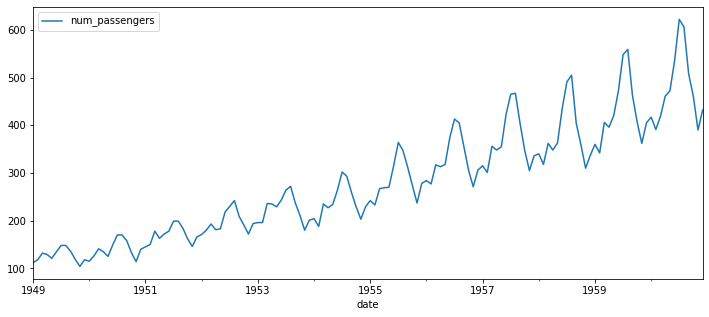

In [3]:
passengers.plot(figsize=(12,5))
plt.show()

Как было отмечено ранее, представленный временной ряд не является стационарным. В нем наблюдаются как тренд, так и сезонность. Кроме того, дисперсия на разных участках ряда не постоянна. Поэтому сначала выполним преобразование Бокса-Кокса.

## 1. Автокорреляция и частичная автокорреляция

Согласно теореме Вольда стационарный ряд можно описать моделью ARMA. Возникает вопрос: как определить порядок авторегрессии и порядок скользящего среднего? Для начала исходный ряд приводят к стационарному. После чего для определения порядка скользящего среднего прибегают к анализу коррелограммы полученного ряда.

In [4]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [5]:
passengers_transformed, lmbda = boxcox(passengers['num_passengers'])
y_transformation = pd.DataFrame(passengers['num_passengers'].values, columns=['initial'])
y_transformation['transformed'] = passengers_transformed
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

In [6]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation['initial'])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(y_transformation['transformed'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.991880
После преобразования Бокса-Кокса: p=0.617162
После сезонного дифференцирования: p=0.052505
После дополнительного дифференцирования: p=0.000304


Рассмотрим коррелограмму полученного ряда.

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

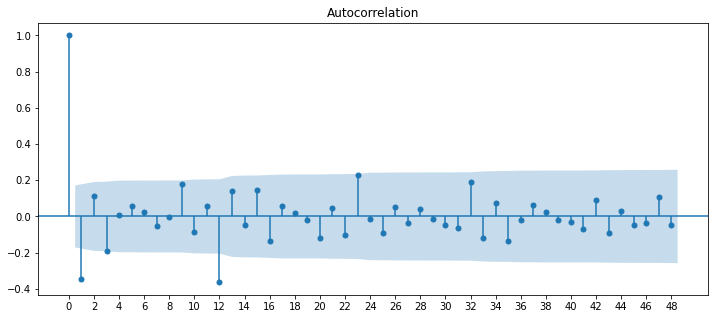

In [8]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

В качестве начального приближения гиперпараметра $q$ берется последний значимый лаг автокорреляции. Для примера выше последний значимый лаг равен 1. При лаге равном 2 значение автокорреляции попадает внутрь голубого "коридора", поэтому дальнейшие значения автокорреляции не рассматриваются, $q_0=1$.

Аналогичным образом определяется начальное приближение для сезонного порядка скользящего среднего $Q$. Необходимо определить последний значимый сезонный лаг автокорреляции. На графике выше последним значимым лагом является 12 (один сезонный период). Соответственно, порядок $Q_0=1$.

**Замечание по терминологии**: гиперпараметрами модели называют те параметры, которые задаются пользователем. Параметрами же называют подобранные путем минимизации функционала качества моделью коэффициенты. Функционалом качества может выступать, например, среднеквадратичная ошибка.

Т.е. когда речь идет о модели $ARIMA(p,d,q)$, гиперпараметрами являются $p$, $d$ и $q$, которые задаются вручную. Параметрами при этом являются коэффициенты $\alpha$, $\phi$ и $\theta$.

Для выбора начального приближения порядка авторегрессии $p$ прибегают к аналогичному методу, но рассматривают частичную автокорреляцию. Частичная автокорреляция &ndash; это автокорреляция после снятия авторегрессии предыдущего порядка. Для определения значения частичной автокорреляции с лагом 2 необходимо построить авторегрессию порядка 1 ($AR(1)$), вычесть эту авторегрессию из ряда и вычислить автокорреляцию на полученных остатках, т.е.:
$$\phi_{hh}=\begin{cases} r(y_{t+1},y_t), & h=1, \\ 
r(y_{t+h}-y_{t+h}^{h-1},y_t-y_t^{h-1}), & h\ge1, \end{cases}$$
где $y_t^{h-1} -$ авторегрессии следующего вида:
$$y_t^{h-1}=\beta_1 y_{t+1}+\beta_2 y_{t+2}+...+\beta_{h-1} y_{t+h-1},$$
$$y_{t+h}^{h-1}=\beta_1 y_{t+h-1}+\beta_2 y_{t+h-2}+...+\beta_{h-1} y_{t+1}.$$

Для построения графика частичной автокорреляции служит функция `plot_pacf`, которая находится в том же модуле `statsmodels.graphics.tsaplots`.

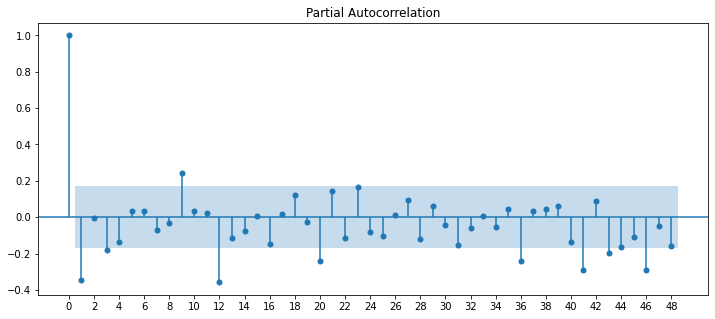

In [9]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Последний значимый лаг также равен 1, соответственно, $p_0=1$. При лаге 24 автокорреляцию можно считать значимой, однако слишком высокий порядок авторегрессии выбирать не рекомендуется. Возьмем $P_0=1$.

Для выбора оптимальных значений гиперпараметров $p$, $q$, $P$ и $Q$ необходимо построить соответствующие модели авторегрессии и оценить их качество. Поскольку вариантов достаточно много, обычно рассматриваются гиперпараметры в окрестности начального приближения  $p_0$, $q_0$, $P_0$, $Q_0$.

In [10]:
p = range(0, 3)
q = range(0, 3)
P = range(0, 2)
Q = range(0, 2)
d = 1

In [11]:
from itertools import product

In [12]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

36

Получили 36 возможных наборов гиперпараметров. Гиперпараметры модели нельзя выбирать методом максимального правдоподобия, поскольку с увеличением количества параметров значение функции правдоподобия $L$ растет. 

Поэтому для сравнения различных моделей применяется информационный критерий Акаике:
$$AIC=-2L+2k,$$
где $k$ &ndash; число параметров модели. Чем меньше значение данного критерия, тем лучше.

## 2. Построение модели SARIMA

Модель SARIMA можно найти в модуле `statsmodels.tsa.statespace.sarimax`. Процесс обучения модели (настройки параметров модели) аналогичен процессу обучения адаптивных методов.

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Обучим модель `SARIMA(1,1,0),(1,1,1)`. В качестве первого аргумента функции `SARIMAX` необходимо передать временной ряд. Чтобы определить порядки авторегрессии, дифференцирования и скользящего среднего необходимо передать их в виде кортежа в аргумент `order`. В данном случае передадим временной ряд, полученный после сезонного дифференцирования, поскольку обычное дифференцирование функция произведет самостоятельно.

In [14]:
model = SARIMAX(y_transformation['initial'], 
                order=(1, 1, 0), 
                seasonal_order=(1, 1, 1, 12)).fit()

Значение критерия Акаике:

In [15]:
model.aic

1020.4927998855601

Прогноз модели также можно получить с помощью функций `forecast` и `predict`.

In [16]:
model.params

ar.L1        -0.322589
ar.S.L12     -0.890945
ma.S.L12      0.791263
sigma2      131.525043
dtype: float64

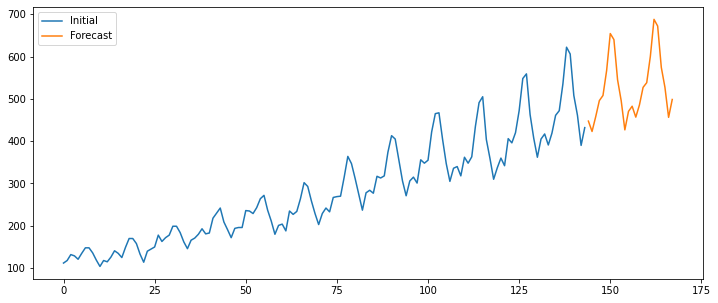

In [17]:
y_transformation['initial'].plot(figsize=(12,5))
model.forecast(24).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()

<div class="alert alert-info">

<h3> Задание 1</h3>
<p></p>
<ol>
<li>Среди ранее полученных наборов гиперпараметров (<b>parameters_list</b>) найдите тот, для которого критерий Акаике минимален.</li>
    <p></p>
<li>С помощью функции <b>predict</b> получите прогноз на 36 точек вперед и отобразите его на графике.</li>
    <p></p>
</ol>
</div>

<p></p>
</div>

1) Среди ранее полученных наборов гиперпараметров (parameters_list) найдите тот, для которого критерий Акаике минимален

In [18]:
p = range(0, 3)
q = range(0, 3)
P = range(0, 2)
Q = range(0, 2)
d = 1

In [19]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

36

In [20]:
list_of_aic=[]
for i in range(len(parameters_list)): #для кажного набора определяем критерий Акаике
    model = SARIMAX(y_transformation['initial'], order=(parameters_list[i][0], 1, parameters_list[i][1]),seasonal_order=(parameters_list[i][2], 1,parameters_list[i][3], 12)).fit()
    list_of_aic.append(model.aic)

C:\Users\Nastya\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nastya\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [21]:
minIndex = list_of_aic.index(min(list_of_aic)) #находим минимальное значение критерия в полученном списке

In [22]:
print(parameters_list[minIndex],list_of_aic[minIndex]) #набор параметров и соответствующее ему мин значение критерия

(2, 1, 0, 0) 1017.8467848726739


2) С помощью функции predict получите прогноз на 36 точек вперед и отобразите его на графике.

In [23]:
model_best = SARIMAX(y_transformation['initial'], 
                order=(parameters_list[minIndex][0], 1, parameters_list[minIndex][1]), 
                seasonal_order=(parameters_list[minIndex][2], 1, parameters_list[minIndex][3], 12)).fit()

In [24]:
model_best.aic

1017.8467848726739

In [25]:
model_best.params

ar.L1       0.595969
ar.L2       0.214279
ma.L1      -0.981878
sigma2    129.313220
dtype: float64

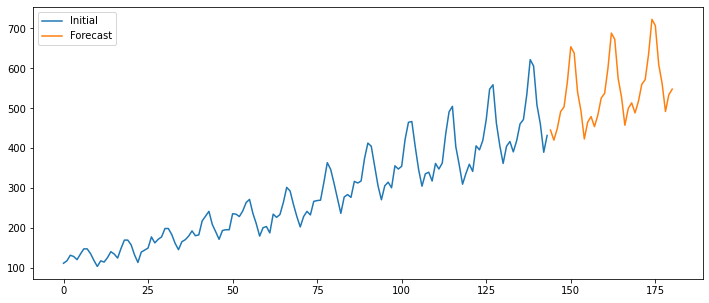

In [26]:
y_transformation['initial'].plot(figsize=(12,5))
model_best.predict(start=y_transformation['initial'].size, end=y_transformation['initial'].size+36).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()

In [27]:
y_transformation

,initial,transformed,seasonal_diff,lag1_diff
0,112,6.827490,NaN,NaN
1,118,6.932822,NaN,NaN
2,132,7.161892,NaN,NaN
3,129,7.114611,NaN,NaN
4,121,6.983787,NaN,NaN
...,...,...,...,...
139,606,10.684049,0.207164,-0.118024
140,508,10.234573,0.231678,0.024514
141,461,9.992159,0.306024,0.074345
142,390,9.582623,0.179190,-0.126833


Рассмотрим другой пример:

In [28]:
data = pd.read_csv('data/monthly-new-york-city-births.csv', index_col=0, parse_dates=True)

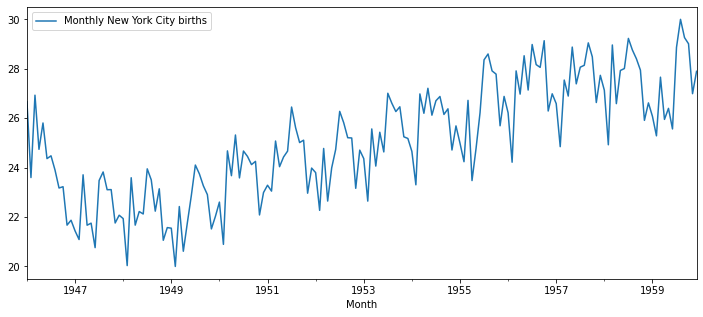

In [29]:
data.plot(figsize=(12,5))
plt.show()

В данном временном ряде присутствуют годовая сезонность и тренд, что можно заметить на коррелограмме:

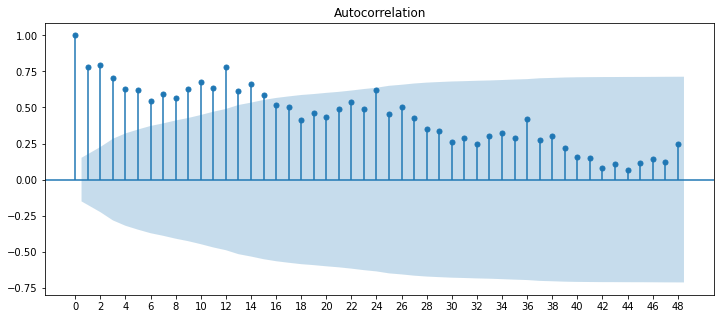

In [30]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(data['Monthly New York City births'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Наличие сезонных закономерностей также можно определить, разложив ряд на составляющие с помощью функции `statsmodels.tsa.seasonal.seasonal_decompose`.

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

В statsmodels применяется следующий алгоритм декомпозиции ряда:

1. Тренд выявляется с помощью скользящего среднего, который затем вычитается из исходного ряда.

2. Сезонность. Полученный ряд группируется по месяцам (если период сезонности &ndash; год, период задается опцией `period`), значения усредняются. Поэтому на графике вы увидите, что максимальные и минимальные значения каждый год совпадают.

3. Остатки. Из исходного ряда вычитаются тренд и сезонность, полученные в 1 и 2. Полученный ряд является рядом остатков.

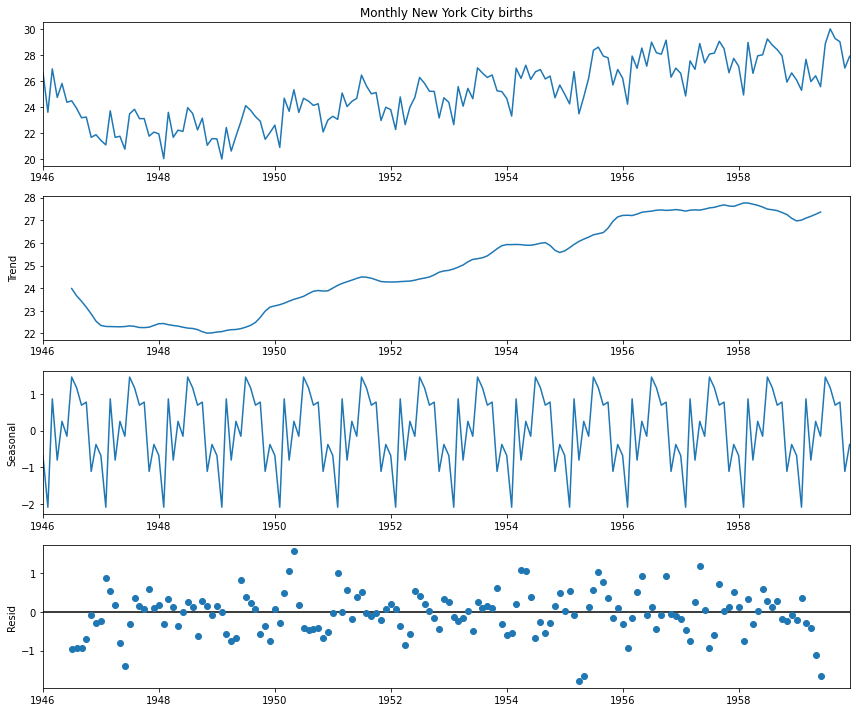

In [32]:
plt.rcParams['figure.figsize'] = (12,10)
seasonal_decompose(data['Monthly New York City births'], period=12).plot()
plt.show()

In [33]:
transformed, lmbda = boxcox(data['Monthly New York City births'])
y_transformation = pd.DataFrame(data['Monthly New York City births'].values, columns=['initial'])
y_transformation['transformed'] = transformed
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

In [34]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation['initial'])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(y_transformation['transformed'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.920956
После преобразования Бокса-Кокса: p=0.920569
После сезонного дифференцирования: p=0.012798
После дополнительного дифференцирования: p=0.000152


Критерий Дики-Фуллера говорит о том, что после сезонного и обычного дифференцирований ряд является стационарным.

<div class="alert alert-info">

<h3> Задание 2</h3>
<p></p>
<ol>
<li>По автокорреляции и частичной автокорреляции определите начальное приближение для порядков авторегресии и скользящего среднего.</li>
    <p></p>
<li>Постройте модель SARIMA с различными наборами гиперпараметров $p, q, P, Q$. Выберите оптимальную модель по критерию Акаике.</li>
    <p></p>
<li>Постройте прогноз на 36 точек вперед.</li>
    <p></p>
</ol>
</div>

<p></p>
</div>

1) По автокорреляции и частичной автокорреляции определите начальное приближение для порядков авторегресии и скользящего среднего.

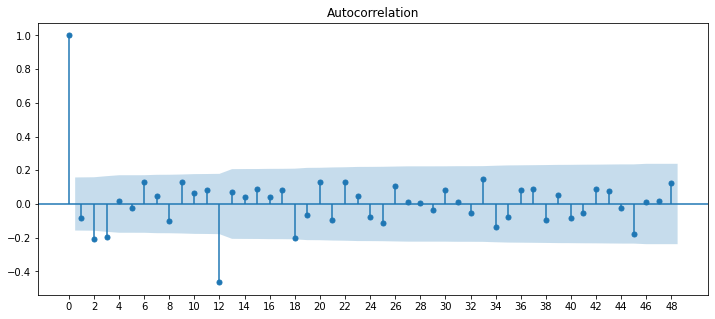

In [35]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

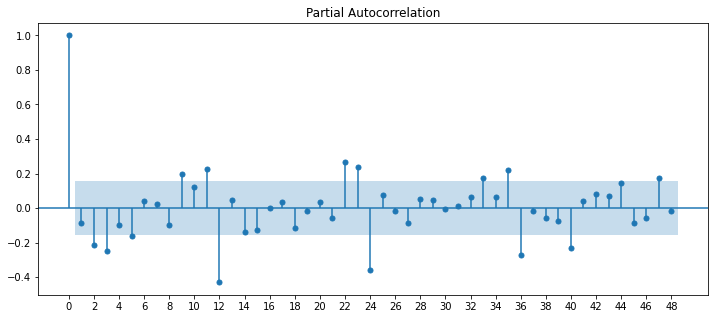

In [36]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

q=0,Q=1,p=0,P=3

2)Постройте модель SARIMA с различными наборами гиперпараметров  𝑝,𝑞,𝑃,𝑄 . Выберите оптимальную модель по критерию Акаике.

In [37]:
p = range(0, 2)
q = range(0, 2)
P = range(1, 4)
Q = range(0, 2)


In [38]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

24

In [39]:
list_of_aic=[]
for i in range(len(parameters_list)): #для кажного набора определяем критерий Акаике
    model = SARIMAX(y_transformation['lag1_diff'], order=(parameters_list[i][0], 1, parameters_list[i][1]),seasonal_order=(parameters_list[i][2], 1,parameters_list[i][3], 12)).fit()
    list_of_aic.append(model.aic)

In [40]:
minIndex = list_of_aic.index(min(list_of_aic)) #находим минимальное значение критерия в полученном списке

In [41]:
print(parameters_list[minIndex],list_of_aic[minIndex],) #набор параметров и соответствующее ему мин значение критерия

(0, 1, 3, 1) 546.6838811752643


In [42]:
model_best = SARIMAX(y_transformation['lag1_diff'], 
                order=(parameters_list[minIndex][0], 1, parameters_list[minIndex][1]), 
                seasonal_order=(parameters_list[minIndex][2], 1, parameters_list[minIndex][3], 12)).fit()

In [43]:
model_best.params

ma.L1      -0.994775
ar.S.L12   -1.076586
ar.S.L24   -0.916277
ar.S.L36   -0.487003
ma.S.L12   -0.989342
sigma2      0.326893
dtype: float64

3)Постройте прогноз на 36 точек вперед.

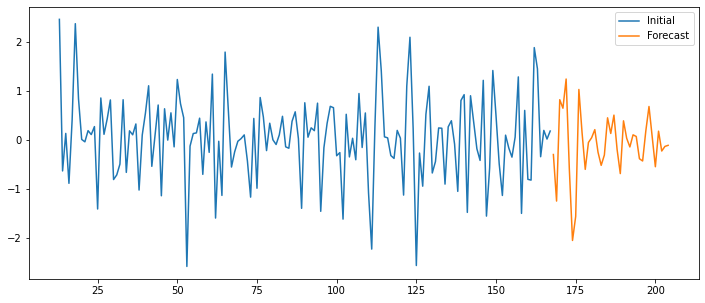

In [47]:
y_transformation['lag1_diff'].plot(figsize=(12,5))
model_best.predict(start=y_transformation['lag1_diff'].size, end=(y_transformation['lag1_diff'].size+36)).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()